<a href="https://colab.research.google.com/github/bubuloMallone/NeuralNetworksLM/blob/main/5_backprop_tensor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Understanding the Backpropagation Algorithm

The aim of this notebook is to implement from scratch the back propagation alogorithm, this time at the tensors level (like the PyTorch .backprop() method) to understand how it works under the hood. This helps also understanding how to use it optimally in further training.

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
import random

In [2]:
# read all the words dataset

!wget https://raw.githubusercontent.com/bubuloMallone/NeuralNetworksLM/refs/heads/main/datasets/names.txt

words = open('names.txt', 'r').read().splitlines()

words[:10]

--2025-09-19 11:05:39--  https://raw.githubusercontent.com/bubuloMallone/NeuralNetworksLM/refs/heads/main/datasets/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.04s   

2025-09-19 11:05:39 (6.13 MB/s) - ‘names.txt’ saved [228145/228145]



['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# build the dataset

# define the context length: how many char we consider to predict the next one
block_size = 3

def build_dataset(words):

  X, Y = [], []
  for word in words:
    context = [0] * block_size
    for ch in word + '.':
      idx = stoi[ch]
      X.append(context)
      Y.append(idx)
      # print(''.join(itos[i] for i in context), '--->', itos[idx])
      context = context[1:] + [idx]
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print('Data:', X.shape, X.dtype)
  print('Labels:', Y.shape, Y.dtype)
  num_samples = X.shape[0]

  return X, Y, num_samples

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr, num_samples_tr = build_dataset(words[:n1])
Xval, Yval, num_samples_val = build_dataset(words[n1:n2])
Xte, Yte, num_samples_te = build_dataset(words[n2:])

Data: torch.Size([182625, 3]) torch.int64
Labels: torch.Size([182625]) torch.int64
Data: torch.Size([22655, 3]) torch.int64
Labels: torch.Size([22655]) torch.int64
Data: torch.Size([22866, 3]) torch.int64
Labels: torch.Size([22866]) torch.int64


First let us define a utility function to compare the manual gradients computed to PyTorch gradients.

In [5]:
# utility function to compare gradients to PyTorch gradients
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')


Now let us initialize the neular network (MLP) as usual

In [6]:
# MLP architecture
g = torch.Generator().manual_seed(2147483647)

emb_dim = 10  # the dimensionality of the character embedding vectors
hidden_dim = 64  # the number of neurons in the hidden layer of the MLP

# embedding
C = torch.randn((vocab_size, emb_dim))
# Layer 1
W1 = torch.randn((block_size * emb_dim, hidden_dim), generator=g) * (5/3)/((block_size * emb_dim)**0.5) # Kaiming init for tanh! * 0.2  # to avoid dead neurons
b1 = torch.randn(hidden_dim, generator=g) * 0.1  # keep b1 just for fun (check the grads) even though it is actually useless
# Layer 2
W2 = torch.randn((hidden_dim, vocab_size), generator=g) * 0.1  # to keep low initial logits
b2 = torch.randn(vocab_size, generator=g) * 0.1   # to keep low initial logits
# BatchNorm parameters
bn_gain = torch.randn((1, hidden_dim)) * 0.1 + 1.0
bn_bias = torch.randn((1, hidden_dim)) * 0.1

# Note: many of these parameters are initialized in non-standard ways because the correct
# initializations sometimes might mask some incorrect implementations of the backward pass


parameters = [C, W1, b1, W2, b2, bn_gain, bn_bias]

# require gradients
for p in parameters:
  p.requires_grad = True

tot_parameters = sum(p.nelement() for p in parameters)
print(f'Total number of parameters: {tot_parameters}')


Total number of parameters: 4137


In [7]:
batch_size = 32
# minibatch construct
idxs = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)  # (num_samples,) --> (batch_size,)
Xb, Yb = Xtr[idxs], Ytr[idxs]  # (batch_size, block_size) and (batch_size,)

Implement the forward pass in small steps sothat is possible to backward at every step.

In [8]:
# Forward pass
# embedd characters into vectors
emb = C[Xb]   # (batch_size, block_size, emb_dim)
# concatenate the vectors
emb_cat = emb.view(emb.shape[0], -1)  # (batch_size, block_size * emb_dim)
# linear layer 1
h_preact = emb_cat @ W1 + b1   # (batch_size, hidden_dim)
# batch norm layer
bn_mean = h_preact.mean(0, keepdim=True)  # (1, hidden_dim)
bn_diff = h_preact - bn_mean  # (batch_size, hidden_dim)
bn_diff2 = bn_diff ** 2
bn_var = bn_diff2.sum(0, keepdim=True) * 1.0/(batch_size-1)  # (1, hidden_dim).  BESSEL CORRECTION unbiased variance
bn_std_inv = (bn_var + 1e-5) ** -0.5  # (1, hidden_dim)
bn_raw = bn_diff * bn_std_inv  # (batch_size, hidden_dim)
# normalize the batch to unit gaussian and then offset/scale it according to learned bn_bias/gain (might add +eps small to std)
h_preact_bn = bn_raw * bn_gain + bn_bias  # (batch_size, hidden_dim)
# non-linear activation
h = torch.tanh(h_preact_bn)   # (batch_size, hidden_dim)
# linear layer 2
logits = h @ W2 + b2    # output (batch_size, alphabet_size)
# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_max = logits.max(1, keepdim=True).values  # (batch_size, 1)
norm_logits = logits - logit_max  # subtract max for numerical stability (batch_size, alphabet_size)
counts = norm_logits.exp() # (batch_size, alphabet_size)
counts_sum = counts.sum(1, keepdim=True) # (batch_size, 1)
counts_sum_inv = counts_sum ** -1  # (batch_size, 1)
probs = counts * counts_sum_inv  # (batch_size, alphabet_size)
logprobs = probs.log()
loss = -logprobs[range(batch_size), Yb].mean()


# PyTorch backward pass
for p in parameters:
  p.grad = None

for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_max, logits, h, h_preact_bn, bn_raw,
         bn_std_inv, bn_var, bn_diff2, bn_diff, h_preact, bn_mean,
         emb_cat, emb]:
  t.retain_grad()

loss.backward()

# Backpropagation implementation 1

Manually implement the backpropagation algorithm to propagate through all the variables defined in the forward pass, one by one.


In [9]:
# Approach 1: backprop through the whole thing manually, one by one,
# through all the variables defined in the forward pass above.

# compute derivatives according to the chain rule dLoss/dparams

# dLoss/dLogprobs = d[- 1/batch_size *(sum_i x_i)]/dx_j = -1/batch_size * 1_ij
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(batch_size), Yb] = -1.0/batch_size
cmp('logprobs', dlogprobs, logprobs)

# dLoss/dProbs = dLoss/dLogprobs * dLogprobs/dProbs = dlogprobs * 1/probs
dprobs = (1.0/probs) * dlogprobs
cmp('probs', dprobs, probs)

# dLoss/dCounts_sum_inv = dLoss/dProbs * dProbs/dCounts_sum_inv
# probs = counts * counts_sum_inv [(batch_size, alphabet_size) * (batch_size, 1)]
# c = a * b with a[3x3], b[3,1] -->
# c : [[a11*b1 a12*b1 a13*b1]
#      [a21*b2 a22*b2 a23*b2]
#      [a31*b3 a32*b3 a33*b3]]
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
dcounts = counts_sum_inv * dprobs

dcounts_sum = (-counts_sum ** -2) * dcounts_sum_inv
cmp('counts_sum', dcounts_sum, counts_sum)

# dLoss/dCounts = dLoss/dCounts_sum * dCounts_sum/dCounts
# counts [(batch_size, alphabet_size)] --> counts_sum [(batch_size, 1)]
# [c11 c12 c13] -->  s1 = c11 + c12 + c13
# [c21 c22 c23] -->  s2 = c21 + c22 + c23
# [c31 c32 c33] -->  s3 = c31 + c32 + c33
dcounts += torch.ones_like(counts) * dcounts_sum
cmp('counts', dcounts, counts)
dnorm_logits = counts * dcounts
cmp('norm_logits', dnorm_logits, norm_logits)
dlogits_max = (-dnorm_logits).sum(1, keepdim=True)
cmp('logits_max', dlogits_max, logit_max)
dlogits = dnorm_logits.clone()
# temp = torch.zeros_like(logits)
# temp[range(batch_size),logits.max(1).indices] = 1
# dlogits += temp * dlogits_max
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogits_max
cmp('logits', dlogits, logits)
dh = dlogits @ W2.T
dW2 = h.T @ dlogits
db2 = dlogits.sum(0)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
dh_preact_bn = (1.0 - h**2) * dh
cmp('h_preact_bn', dh_preact_bn, h_preact_bn)
dbn_raw = dh_preact_bn * bn_gain
cmp('bn_raw', dbn_raw, bn_raw)
dbn_gain = (bn_raw * dh_preact_bn).sum(0, keepdim=True)
cmp('bn_gain', dbn_gain, bn_gain)
dbn_bias = dh_preact_bn.sum(0, keepdim=True)
cmp('bn_bias', dbn_bias, bn_bias)
dbn_diff = dbn_raw * bn_std_inv
dbn_std_inv = (dbn_raw * bn_diff).sum(0, keepdim=True)
cmp('bn_std_inv', dbn_std_inv, bn_std_inv)
dbn_var = (-0.5 * (bn_var + 1e-5)**-1.5) * dbn_std_inv
cmp('bn_var', dbn_var, bn_var)
dbn_diff2 = torch.ones_like(bn_diff2) * dbn_var * 1.0/(batch_size-1)
cmp('bn_diff2', dbn_diff2, bn_diff2)
dbn_diff += 2* bn_diff * dbn_diff2
cmp('bn_diff', dbn_diff, bn_diff)
dbn_mean = (- dbn_diff).sum(0, keepdim=True)
cmp('bn_mean', dbn_mean, bn_mean)
dh_preact = dbn_diff
dh_preact += (torch.ones_like(h_preact) * dbn_mean * 1.0/(batch_size))
cmp('h_preact', dh_preact, h_preact)
demb_cat = dh_preact @ W1.T
cmp('emb_cat', demb_cat, emb_cat)
dW1 = emb_cat.T @ dh_preact
db1 = dh_preact.sum(0)
cmp('emb_cat', demb_cat, emb_cat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
demb = demb_cat.view(emb.shape)
cmp('emb', demb, emb)
dC = torch.zeros_like(C)
for i in range(Xb.shape[0]):
  for j in range(Xb.shape[1]):
    dC[Xb[i,j]] += demb[i,j]
cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logits_max      | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
h_preact_bn     | exact: False | approximate: True  | maxdiff: 4.656612873077393e-10
bn_raw          | exact: False | approximate: True  | maxdiff: 6.984919309616089e-10
bn_gain         | exact: False | approximate: True  | maxdiff: 1.862645149230957e-09
bn_bias 

# Backpropagation implementation 2

Backpropagation through the cross_entropy loss function all in one step.


In [10]:
# Approach 2: consider the mathematical expression of the loss,
# to take the derivative, simplify the expression, and use the final result.

# forward pass

# before:
# cross entropy loss (same as F.cross_entropy(logits, Yb))
# logit_max = logits.max(1, keepdim=True).values  # (batch_size, 1)
# norm_logits = logits - logit_max  # subtract max for numerical stability (batch_size, alphabet_size)
# counts = norm_logits.exp() # (batch_size, alphabet_size)
# counts_sum = counts.sum(1, keepdim=True) # (batch_size, 1)
# counts_sum_inv = counts_sum ** -1  # (batch_size, 1)
# probs = counts * counts_sum_inv  # (batch_size, alphabet_size)
# logprobs = probs.log()
# loss = -logprobs[range(batch_size), Yb].mean()

# now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

3.393766403198242 diff: 0.0


In [12]:
# backward pass

dlogits = F.softmax(logits, 1)
dlogits[range(batch_size), Yb] -= 1
dlogits /= batch_size

cmp('logits', dlogits, logits) # I can only get approximate to be true, my maxdiff is 6e-9

logits          | exact: False | approximate: True  | maxdiff: 4.6566128730773926e-09


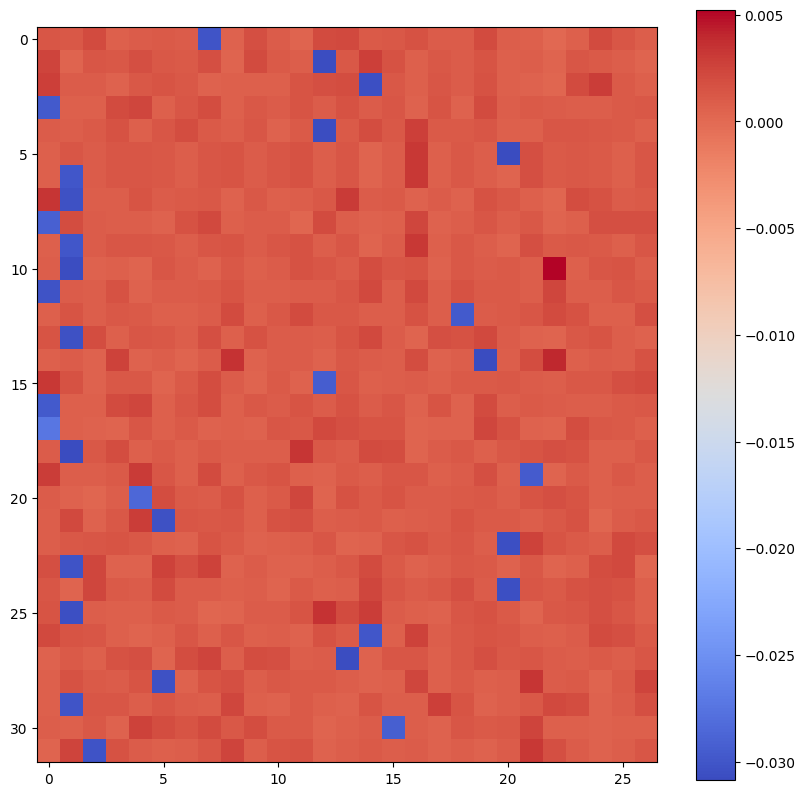

In [30]:
plt.figure(figsize=(10, 10))
# Calculate the absolute maximum value of the gradients to set symmetric limits
# max_abs = torch.abs(dlogits.detach()).max()
# plt.imshow(dlogits.detach(), cmap='coolwarm', vmin=-max_abs, vmax=max_abs)
plt.imshow(dlogits.detach(), cmap='coolwarm')
plt.colorbar()
plt.show()

In [31]:
dlogits.sum(1)

tensor([ 3.7253e-09,  1.3970e-09, -6.9849e-10, -9.3132e-10, -1.3970e-09,
         2.3283e-09,  4.6566e-10,  2.3283e-09, -6.9849e-10,  4.6566e-10,
        -9.3132e-10, -6.9849e-10, -4.6566e-10, -2.3283e-09, -1.1642e-09,
         4.6566e-10, -9.3132e-10,  1.8626e-09,  9.3132e-10, -9.3132e-10,
         1.8626e-09, -1.3970e-09, -3.2596e-09,  1.3970e-09, -9.3132e-10,
        -4.6566e-10, -4.6566e-10,  1.3970e-09,  1.1642e-09, -4.6566e-10,
        -1.8626e-09,  9.3132e-10], grad_fn=<SumBackward1>)

# Backpropagation implementation 3

Backpropagation through the Batch Norm steps all in one.

In [32]:
# Approach 3: consider the mathematical expression of the batchnorm output,
# take the derivative w.r.t. its input, simplify and use the resulting expression

# forward pass

# before:
# batch norm layer
bn_mean = h_preact.mean(0, keepdim=True)  # (1, hidden_dim)
bn_diff = h_preact - bn_mean  # (batch_size, hidden_dim)
bn_diff2 = bn_diff ** 2
bn_var = bn_diff2.sum(0, keepdim=True) * 1.0/(batch_size-1)  # (1, hidden_dim).  BESSEL CORRECTION unbiased variance
bn_std_inv = (bn_var + 1e-5) ** -0.5  # (1, hidden_dim)
bn_raw = bn_diff * bn_std_inv  # (batch_size, hidden_dim)
# normalize the batch to unit gaussian and then offset/scale it according to learned bn_bias/gain (might add +eps small to std)
h_preact_bn = bn_raw * bn_gain + bn_bias  # (batch_size, hidden_dim)

# now:
hpreactbn_fast = bn_gain * (h_preact - h_preact.mean(0, keepdim=True)) / torch.sqrt(h_preact.var(0, keepdim=True, unbiased=True) + 1e-5) + bn_bias
print('max diff:', (hpreactbn_fast - h_preact_bn).abs().max())


max diff: tensor(4.7684e-07, grad_fn=<MaxBackward1>)


In [ ]:
# backward pass

# calculate dh_preact given dh_preact_bn (i.e. backprop through the batchnorm)
# (you'll also need to use some of the variables from the forward pass up above)

dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bn_raw).sum(0))

cmp('hprebn', dhprebn, hprebn) # I can only get approximate to be true, my maxdiff is 9e-10
